# Geaph Convolution Neural Network

- 분자의 그래프 표현방식과 그래프 컨볼류션 네트워크의 이해
- 분자를 그래프로 표현하는 예

![Molecular Graph](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/assets/basic_graphs.gif?raw=1)



## Graph Convolutions 개념

- 일반 CNN
 - 이미지 처리, 시계열 처리 등에 사용
 - 신호가 주변의 샘플들과 같이 필터를 통과하면서 어떤 추상적인 패턴을 추출한다
 - 컨볼류션 계층을 여러번 통과하면서 점차 추상적인 패턴을 찾는다 
 - 가끔 풀링(max pooling)을 수행하여 패턴신호(특성)의 공간적인 이동과 정보 축약을 수행한다
 - [CNN 개요](https://medium.com/@ricardo_fideles/dog-breed-classification-with-cnn-827963a67bdf), [이미지 필터링](https://setosa.io/ev/image-kernels/), [CNN 동작 설명](https://transcranial.github.io/keras-js/#/mnist-cnn)
- 그래프 CNN
 - 일반 CNN과 유사하나 이미지가 시계열 데이터가 아니라 그래프로 표현된 입력을 대상으로 동작한다
 - 주변 샘플 전체가 아니라 그래프로 연결된 샘플들을 사용하여 컨볼류션과 풀링을 수행한다
 - [Distill GCN](https://distill.pub/2021/gnn-intro/)


## 용해도 예측
- 물질이 용매에 포화상태까지 녹을 수 있는 한도
- 분자 구조 정보로부터 용해도(y)를 예측
- 알려진 실제 화합물의 용해도로부터,유사한 화합물의 용해도를 예측하는 데 사용
- Fingerprint를 이용하는 경우와 비교
- DeepChem 라이브러리 사용법
 - MoleculeNet 사용

##  데이터
- 데이터를 MoleculeNet에서 가져오며 Delaney solubility data set을 사용
 - 존 델라니가 2004년에 발표한 논문 데이터
 - log(solubility) measured in moles/liter
- load_delaney() 함수로 데이터를 다운받는다
 - 아래에서는 특성(feature, 표현법)으로 그래프 구조 정보를 사용한다고 선택했다
 - 다운받은 데이터를 세가지 정보를 제공한다 (작업, 데이터, 변환)
 - 데이터는 훈련, 검증, 테스트 세가지로 구성되어 있다

## 모델
- 랜덤 포레스트
 - CircularFingerprint 사용
- 그래프 컨볼류션 네트워크
 - featurizer='GraphConv' 사용
 - 각 분자는 ConvMol 객체로 표현된다

# Import

In [1]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import tensorflow as tf
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.feat.mol_graphs import ConvMol
import tensorflow.keras.layers as layers
from deepchem.metrics import to_one_hot



# import tempfile
# from itertools import islice
# from IPython.display import Image, display
# from deepchem.utils.data_utils import load_from_disk  

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 데이터

- 다운로드 방법
 - csv 파일을 직접 다운로드 받아서 사용하는 경우
 - deepchem의 load_delaney() 함수를 사용하는 경우
 
- 모델 성능 비교
 - 랜덤포레스트를 사용하는 경우와 GCN을 사용하는 경우의 성능을 비교한다
 - 특성은 각각 Fingerprint와 그래프 모델을 사용한다

# csv 파일을 다운로드 하는 방법
- X, y 등을 나누어주어야 한다

In [3]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-11-09 11:31:35--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.1’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.002s  

2022-11-09 11:31:36 (52.3 MB/s) - ‘delaney-processed.csv.1’ saved [96699/96699]



In [4]:
dataset = pd.read_csv("delaney-processed.csv")
print(dataset.shape)
dataset[:3]

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


## Deepchem이 제공하는 load_  함수를 사용하는 방법
- 특성을 ECFP 로 선택

In [6]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP')
train_dataset, valid_dataset, test_dataset = datasets

In [7]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

# 램덤포레스트 모델
-`deepChem`은 `SklearnModel`을 통해서 `scikit-learn` 의 모델들을 사용할 수 있게 한다

In [8]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
dc_rfr = dc.models.SklearnModel(rfr)

#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
dc_rfr.fit(train_dataset)

## 모델 학습과 성능 평가
- `deepchem`의 `Evaluator` 객체의 `compute_model_performance()`로 평가

In [9]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(dc_rfr, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.14869187879616863, 'rms_score': 1.8239545884810016}


## 모델 최적화
- 하이퍼 파라미터 튜닝 수행
- model_dir은 dc.models.SklearnModel 함수의 인자로 다른 디렉토리에 생성한 모델이 있는 경우에 불러오기 위한 인자임

In [10]:
def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  rfr = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(rfr, model_dir)

#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [50, 100],
    "max_features": [0.1, 0.15, 0.2],
    "max_depth" : [17, 19, 21]
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴한다
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [11]:
#최고 성능을 얻은 모델 하이퍼파라미터 출력
print(best_rf_hyperparams)
#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 50, 'max_features': 0.1, 'max_depth': 21}
{'_max_depth_17_max_features_0.100000_n_estimators_50': 0.2312846355326954, '_max_depth_19_max_features_0.100000_n_estimators_50': 0.19312205681291283, '_max_depth_21_max_features_0.100000_n_estimators_50': 0.2718396282573826, '_max_depth_17_max_features_0.150000_n_estimators_50': 0.22962075950573813, '_max_depth_19_max_features_0.150000_n_estimators_50': 0.2325768141217991, '_max_depth_21_max_features_0.150000_n_estimators_50': 0.22810474265621872, '_max_depth_17_max_features_0.200000_n_estimators_50': 0.18410287430965266, '_max_depth_19_max_features_0.200000_n_estimators_50': 0.2112643927651503, '_max_depth_21_max_features_0.200000_n_estimators_50': 0.21177210667219337, '_max_depth_17_max_features_0.100000_n_estimators_100': 0.2436360135074035, '_max_depth_19_max_features_0.100000_n_estimators_100': 0.2464662242621477, '_max_depth_21_max_features_0.100000_n_estimators_100': 0.2597888553728922, '_max_depth_17_max_features_0.15

In [12]:
# 최대 성능값 찾기 (R2)
max(all_rf_results.values())

0.2718396282573826

In [13]:
# 딕셔너리에서 최대 value를 갖는 키 찾기
max(all_rf_results, key=all_rf_results.get)

'_max_depth_21_max_features_0.100000_n_estimators_50'

# 컨볼류션 모델을 사용
- load_delaney() 함수를 사용하여 데이터를 다운로드하면서 featurizer 옵션을 선택


In [14]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [15]:
train_dataset.X[0]

## 모델 구성
- GraphConvModel 클래스를 사용한다
- 이 프로그램에서 사용할 객체 이름을 dc_gcn이라고 지정함
 - 객체에서는 클래스에서 미리 정의된 함수와 파라미터들을 사용할 수 있게 된다
- 회귀분석이며 작업(목적 변수 y) 수는 하나임을 표현
- dropout=0.2 : 데이터를 랜덤하게 20% 사용하지 않도록 지정 (더 다양한 데이터를 사용한 효과를 얻어 성능을 개선시킴)



# 학습
- 훈련 데이터를 몇 번 반복하여 사용할지를 지정한다 (nb_epoch)


In [16]:
dc_gcn = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)
dc_gcn.fit(train_dataset, nb_epoch=100)

0.11205826759338379

# 모델 평가

- 훈련된 모델의 성능을 평가한다.
 - evaluate() 함수를 사용하겠다
 - 측정할 성능평가 지표(metrics)로 mae와 r2_score 사용
- 훈련 데이터에 대한 성능과, 검증 데이터에 대한 성능을 모두 출력해본다 (과대적합인지를 파악하기 위함)

In [32]:
metric1 = dc.metrics.Metric(dc.metrics.mae_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)
print("Training set score:", dc_gcn.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", dc_gcn.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'mae_score': 0.620652821895414, 'r2_score': 0.8603023945833869}
Test set score: {'mae_score': 1.1082442066799347, 'r2_score': 0.5799913489486941}


- R2 점수로 0.55를 얻었다

## 샘플 테스트 데이터에 대한 예측

In [17]:
solubilities = dc_gcn.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-1.8183981] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.6110654] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.8821956] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.9630262] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.6742145] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.8605038] [1.10168349] CC1CO1
[-0.09658935] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.7900317] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.8380014] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[-0.20560876] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[-0.03700038] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[-0.08178218] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[0.13002616] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-0.55123603] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.31811467] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-0.4345729] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-1.1742231] [-1.27744393] CC23Cc1cn

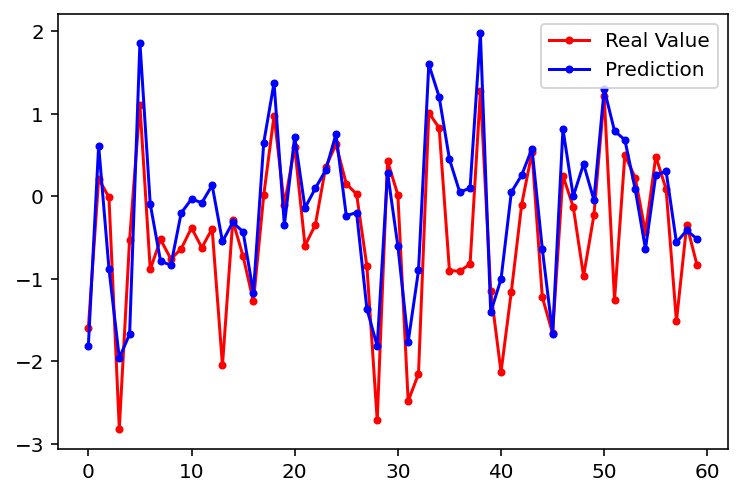

In [18]:
# 60개의 테스트 샘플만 비교했다
plt.plot(test_dataset.y[:60], "r.-", label='Real Value')
plt.plot(solubilities[:60], "b.-",  label='Prediction')
plt.legend()

## 임의의 샘플에 적용해보기

In [20]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = dc_gcn.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.09601074]

Molecule: CCOC(=O)CC
Predicted solubility: [1.5428964]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [0.29818463]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.27200127]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-0.85573596]


## ConvMol  소개

In [21]:
x[1]

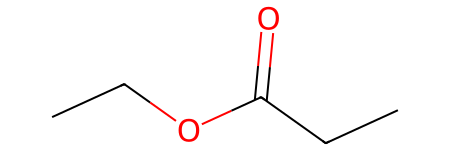

In [22]:
# 두번째 분자 보기
mol = Chem.MolFromSmiles("CCOC(=O)CC")
# for atom in mol.GetAtoms():
#   atom.SetAtomMapNum(atom.GetIdx())
mol

In [51]:
# ConvMol 특성의 구조 (원자가 7이고, 특성 벡터수가 75임)
x[1].atom_features.shape

(7, 75)

In [52]:
x[1].get_atom_features()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.

In [53]:
# 7개 원자의 인접 노드 번호들 보기
x[1].get_adjacency_list()

[[3], [6], [5], [0, 4], [3, 6], [6, 2], [4, 1, 5]]

# 분류에 적용 예
- tox21 데이터 다운로드
- featurizer='GraphConv' 적용

In [23]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

# 모델 정의, 학습, 평가
- GraphConvModel 모델 사용
- 기본 모델 구조를 사용한다

In [24]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)
metric1 = dc.metrics.Metric(dc.metrics.roc_auc_score)
metric2 = dc.metrics.Metric(dc.metrics.accuracy_score)
print('Training set score:', model.evaluate(train_dataset, [metric1, metric2], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.973879072547538, 'accuracy_score': 0.903230097914006}
Test set score: {'roc_auc_score': 0.7005144375300528, 'accuracy_score': 0.7938988095238094}


# GCN을 직접 구현하는 방법
-  `GraphConv` layer: 그래프 컨볼류션을 수행 
- `GraphPool` layer: 주변 노드의 특성 벡터로부터 max-pooling을 수행

- `GraphGather`: 노드(원자) 단위의 특성을 수집하여 그래프 단위(분자)의 특성을 계산: a graph level feature vector 

- 이외에 [Dense](https://keras.io/api/layers/core_layers/dense/), [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/), [Softmax](https://keras.io/api/layers/activation_layers/softmax/) 를 사용한다

In [29]:
batch_size = 100

class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(n_tasks*2)
    self.logits = layers.Reshape((n_tasks, 2))
    self.softmax = layers.Softmax()

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + inputs[1:])

    logits_output = self.logits(self.dense2(readout_output))
    return self.softmax(logits_output)

In [33]:
# 케라스 모델 사용
gcn_model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

In [ ]:
# 입력은 ConvMol 타입임
test_dataset.X[0]

# 입력 데이터 생성

- 모델은 ndarray 타입의 어레이를 사용하므로 `ConvMol` 객체로부터 X, y, w 를 생성해 주는 함수가 필요하다
- 배치단위로 데이터를 생성해야 한다
- 주요 변수:
 - `atom_features`: 각 원자에 대한 특성 표현 벡터이며 크기는 75이다. 
 - `degree_slice`: 주어진 degree에 대해서 원자를 구분하는 인덱싱 
 - `membership`: 분자 내에서 원자의 멤버쉽을 정의 (atom `i` belongs to molecule `membership[i]`). `deg_adjs`: 특정 degree에 대한, 인접 원자 리스트
 
- [구현 소스 코드](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py)

## Data Generator
- X, y, w를 계속 자동으로 생성해주는 함수 정의

In [39]:
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, 
              epochs, deterministic=False, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b)
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, 
              np.array(multiConvMol.membership)]
              
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
    weights = [w_b]
    yield (inputs, labels, weights)

- 모델을 훈련시키기 위해서 fit_generator(generator)를 사용한다
 - generator는 위에서 정의한 data_generator 함수가 생성해준다

In [41]:
# from re import VERBOSE
gcn_model.fit_generator(data_generator(train_dataset, epochs=50))

0.23925519943237306

## 성능 평가
- 위에서 정의한 generator를 사용한다

In [42]:
print('Training set score:', gcn_model.evaluate_generator(data_generator(train_dataset), [metric1, metric2], transformers))
print('Test set score:', gcn_model.evaluate_generator(data_generator(test_dataset), [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.8066417494053058, 'accuracy_score': 0.9205687830687831}
Test set score: {'roc_auc_score': 0.6268907755994892, 'accuracy_score': 0.8933333333333335}
